In [1]:
import numpy as np
import imageio
import tensorflow as tf
import keras

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

from image_basic_operations import *
from image_feature_extraction import *

from skimage import exposure

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Loaded a set of images
root_dir = "training/"


image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(20, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

#n = 18 # Only use 10 images for training

Loading 20 images
satImage_026.png
Loading 20 images
satImage_026.png


# Image pre-processing

## Grey scale

In [3]:
imgs_array = np.asarray(imgs)
gt_array = np.asarray(gt_imgs)

temp = imgs_array.copy()
new_imgs = improve_image_contrast(temp)

In [4]:
# convert images to grey scale.
imgs_array_grey = np.mean(new_imgs, axis = 3)

<function matplotlib.pyplot.show(*args, **kw)>

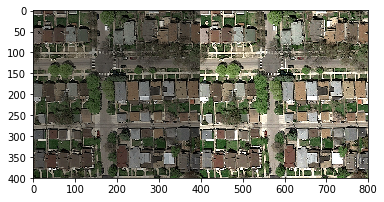

In [5]:
cimg = np.concatenate((imgs_array[4], new_imgs[4]), axis = 1)
plt.imshow(cimg, cmap='Greys_r')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

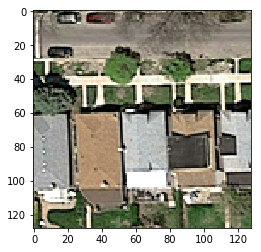

In [7]:
row = 110
col = 200
inc = 128
plt.imshow(new_imgs[4][row:row+inc,col:col+inc], cmap='Greys_r')
plt.show

In [8]:
imgs_patch_array = imgs_array_to_imgs_patch_array(imgs_array_grey, patch_size=128, pixel_increment=16)
gt_patches_array = imgs_array_to_imgs_patch_array(gt_array, patch_size=128, pixel_increment=16)
gt_patches_array = contineous_to_binary_mask(gt_patches_array, 0.3)
imgs_patch_array.shape

(6480, 128, 128)

In [10]:
imgs_array_recombined = imgs_patch_array_to_imgs_array(imgs_patch_array, imgs_array_grey.shape[0], imgs_array_grey.shape[1], patch_size = 128)

Pose per Image : 324
Image Array Size : (20, 400, 400)
Patch Array Size : (6480, 128, 128)


<function matplotlib.pyplot.show(*args, **kw)>

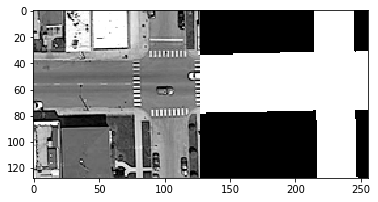

In [11]:
plt.imshow(np.concatenate((imgs_patch_array[-15], gt_patches_array[-15]), axis = 1), cmap='Greys_r')
plt.show

# Dataset Split  

In [12]:
X = imgs_patch_array
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], 1))
Y = gt_patches_array
Y = np.reshape(Y, (Y.shape[0], Y.shape[1], Y.shape[2], 1))

print("X, Y have size : {0}, {1}".format(X.shape, Y.shape))

i = int(0.8*X.shape[0])
j = X.shape[0] - i
X_train = X[:i, :, :, :]
y_train = Y[:i, :, :, :]
X_test = X[-j:, :, :, :]
y_test = Y[-j:, :, :, :]

print("X_train, Y_train have size : {0}, {1}".format(X_train.shape, y_train.shape))
print("X_test, Y_test have size : {0}, {1}".format(X_test.shape, y_test.shape))


X, Y have size : (6480, 128, 128, 1), (6480, 128, 128, 1)
X_train, Y_train have size : (5184, 128, 128, 1), (5184, 128, 128, 1)
X_test, Y_test have size : (1296, 128, 128, 1), (1296, 128, 128, 1)


# Data augmentation

### Using Kera embedded functions

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    fill_mode = 'constant',
    cval = 0,
    width_shift_range=0,
    height_shift_range=0,
    validation_split = 0.8
    horizontal_flip=False)

X_augm = datagen.flow(X_train, y_train, seed = 1, batch_size = 32, save_to_dir = 'augmented_images', save_prefix = '', save_format = 'png')


In [ ]:
# we create two instances with the same arguments
data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=90,
                     width_shift_range=0,
                     height_shift_range=0,
                     zoom_range=0, 
                     fill_mode = 'constant',
                     validation_split = 0.8,
                     cval = 0)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1

image_generator = image_datagen.flow(X_train, y_train, seed = seed, batch_size = 32, 
                                     save_to_dir = 'augmented_images', save_prefix = '', 
                                     save_format = 'png')



### Manually rotating images

In [13]:
X_rot = np.rot90(X_train, k = 1, axes = (1, 2))
X_train_augm = np.concatenate((X_train, X_rot), axis = 0)

(5184, 128, 128, 1) (10368, 128, 128, 1)


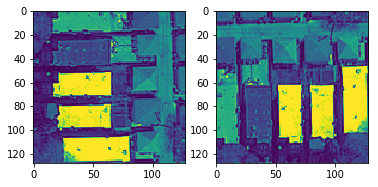

In [14]:
nb_train_img = X_train.shape[0]
plt.subplot(1,2,1)
plt.imshow(np.squeeze(X_train_augm[0]))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(X_train_augm[nb_train_img]))
print(X_train.shape, X_train_augm.shape)

# Train Model

### Using data_generator

In [ ]:
model.fit_generator(image_generator, steps_per_epoch=len(X_train) / 32, epochs=5)

### Using Data Array

In [ ]:
model.fit(X_train, y_train, batch_size = 16, epochs= 10, validation_split = 0.2)

Train on 4147 samples, validate on 1037 samples
Epoch 1/10
4147/4147 [==============================] - 863s 208ms/step - loss: 0.5964 - acc: 0.6985 - val_loss: 0.3980 - val_acc: 0.8158
Epoch 2/10
1488/4147 [=========>....................] - ETA: 8:22 - loss: 0.4098 - acc: 0.8057

# Build Model

In [16]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [21]:
batch_size = 128
input_size = (batch_size, batch_size, 1)
inputs = Input(input_size)

nb_filter = 16

conv1 = Conv2D(nb_filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(nb_filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(nb_filter * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(nb_filter * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(nb_filter * 2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(nb_filter * 2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(nb_filter * 2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(nb_filter * 2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(nb_filter * 2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(nb_filter * 2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(nb_filter * 2**3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(nb_filter * 2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(nb_filter * 2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(nb_filter * 2**2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(nb_filter * 2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(nb_filter * 2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(nb_filter * 2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(nb_filter * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(nb_filter * 2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(nb_filter, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(nb_filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(nb_filter, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

/home/hadrien/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

## Predict

In [ ]:
Z = model.predict(X_test)

In [ ]:
np.sum(Z)

In [ ]:
plt.imshow(X_test[1192, :, :, 0], cmap='Greys_r')
plt.show

In [ ]:
plt.imshow(Z[1192, :, :, 0], cmap='Greys_r')
plt.show

In [ ]:
Z_temp = np.reshape(Z, (Z.shape[0], Z.shape[1], Z.shape[2])) 
Z_imgs_array = imgs_patch_array_to_imgs_array(Z_temp, int(0.2 * imgs_array_grey.shape[0]), imgs_array_grey.shape[1])

# Transform to binary
Z_imgs_array_binary = [contineous_to_binary_mask(mask, 0.5) for mask in Z_imgs_array]
Z_imgs_array_binary = np.asarray(Z_imgs_array_binary)
Z_imgs_array_binary = np.squeeze(Z_imgs_array_binary)

In [ ]:
from display_helper import *
i = 3
i_true = int(i + 0.8* imgs_array_grey.shape[0])   
_ = display_greyimg_mask_pred(imgs_array_grey[i_true], gt_array[i_true], Z_imgs_array_binary[i])

In [ ]:
i = 3
i_true = int(i + 0.8* imgs_array_grey.shape[0])
_ = display_img_with_pred(imgs_array[i_true], Z_imgs_array_binary[i])

In [ ]:
A = np.array([[1,2], [3, 4], [2, 2], [7, 8]])
B = np.array([[1,2], [3, 4], [5, 6]])
C = np.concatenate((B, A), axis = 0) 
print(A.shape, B.shape)

In [ ]:
i = 3
i_true = int(i + 0.8* imgs_array_grey.shape[0])
plt.imshow(np.concatenate((imgs_array_grey[i_true], Z_imgs_array_binary[i], gt_array[i_true]), axis = 1), cmap='Greys_r')
plt.show

In [ ]:
Z_imgs_array.shape

In [ ]:
int(0.8 * imgs_array_grey.shape[0])

# Save Model

In [ ]:
from keras.models import load_model

model.save("20samples_data_augmented90")

# Load Model

In [ ]:
title = '20samples_data_augmented90'
model = load_model(title)